In [1]:
from glob import glob
import pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Flatten, Reshape, RNN
from sklearn.metrics import confusion_matrix
from keras.utils import np_utils
from sklearn.metrics import accuracy_score
import random
import keras.callbacks
from tensorflow.keras.models import load_model, model_from_json

2.1.0


Using TensorFlow backend.


In [103]:
file_list = glob(r"D:\ticker\*csv")

df = pd.DataFrame()
random.seed(50)
file_list_random = random.sample(file_list, 50)
k = 0
for i in tqdm( file_list_random ):
    temp_df = pd.read_csv(i)
    mn = MinMaxScaler()
    X_std = mn.fit_transform(temp_df.iloc[:, :-1].T).T
    y = temp_df.iloc[:, -1].values

    temp = np.hstack([X_std, y.reshape(-1, 1)])
    temp_df = pd.DataFrame(temp, columns=temp_df.columns.values)
    df = pd.concat([df, temp_df])
    k += 1
  #if k > 200:
  #  break

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:25<00:00,  1.98it/s]


In [109]:
df.to_csv("df.csv", index=None)

In [2]:
df = pd.read_csv("df.csv")

In [3]:
len(df)

163883

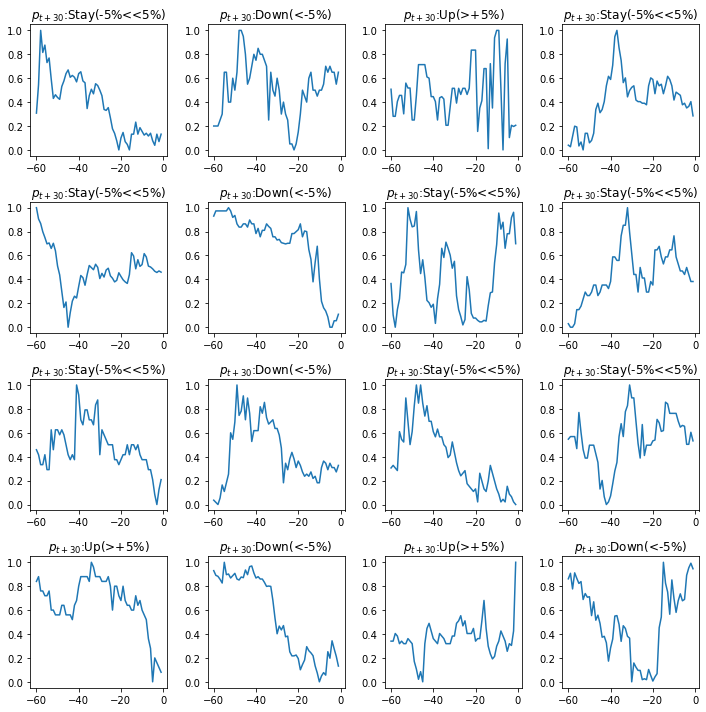

In [44]:
plt.figure(figsize=(10, 10), tight_layout=True)
k = 1
for i in random.sample(np.arange(len(df)).tolist(), 16):
    plt.subplot(4, 4, k)
    k += 1
    plt.plot(np.arange(-60, 0, 1), df.iloc[i, 0:60].values)
    if df.iloc[i, -1] < 5:
        plt.title("$p_{t+30}$:Up(>+5%)")
        #plt.title("Up")
    elif df.iloc[i, -1] == 5:
        plt.title("$p_{t+30}$:Stay(-5%<<5%)")
    else:
        plt.title("$p_{t+30}$:Down(<-5%)")
plt.show()

In [113]:
print(file_list_random)

['D:\\ticker\\7255.csv', 'D:\\ticker\\5108.csv', 'D:\\ticker\\6303.csv', 'D:\\ticker\\4777.csv', 'D:\\ticker\\7057.csv', 'D:\\ticker\\6072.csv', 'D:\\ticker\\3577.csv', 'D:\\ticker\\7618.csv', 'D:\\ticker\\5987.csv', 'D:\\ticker\\4653.csv', 'D:\\ticker\\7769.csv', 'D:\\ticker\\3578.csv', 'D:\\ticker\\4080.csv', 'D:\\ticker\\6188.csv', 'D:\\ticker\\3674.csv', 'D:\\ticker\\6189.csv', 'D:\\ticker\\5999.csv', 'D:\\ticker\\4635.csv', 'D:\\ticker\\4428.csv', 'D:\\ticker\\3466.csv', 'D:\\ticker\\6067.csv', 'D:\\ticker\\6736.csv', 'D:\\ticker\\3624.csv', 'D:\\ticker\\3443.csv', 'D:\\ticker\\6094.csv', 'D:\\ticker\\6744.csv', 'D:\\ticker\\1344.csv', 'D:\\ticker\\4669.csv', 'D:\\ticker\\6134.csv', 'D:\\ticker\\6775.csv', 'D:\\ticker\\3738.csv', 'D:\\ticker\\4499.csv', 'D:\\ticker\\6839.csv', 'D:\\ticker\\5208.csv', 'D:\\ticker\\6958.csv', 'D:\\ticker\\3907.csv', 'D:\\ticker\\5194.csv', 'D:\\ticker\\4555.csv', 'D:\\ticker\\7597.csv', 'D:\\ticker\\3865.csv', 'D:\\ticker\\6594.csv', 'D:\\ticker\\38

In [12]:
target = df.iloc[: , -1]

In [13]:
target_rev = pd.Series( np.where(target<5, 0, np.where(target>5, 2,      np.where(target==5, 1, target))) )

In [14]:
target_rev.value_counts()

1.0    57960
0.0    55374
2.0    50549
dtype: int64

In [15]:
target_categorical = np_utils.to_categorical(target_rev)

In [16]:
target_categorical[target_rev == 0]

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

In [17]:
target_categorical[target_rev == +1]

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

In [18]:
target_categorical[target_rev == 2]

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [19]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(df.iloc[:, 0:60], target_rev, random_state=1)

In [20]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(df.iloc[:, 0:60], target_categorical, random_state=1)

In [21]:
y_train1.value_counts()

1.0    43494
0.0    41565
2.0    37853
dtype: int64

In [22]:
y_train1.value_counts()/np.sum(y_train1.value_counts())

1.0    0.353863
0.0    0.338169
2.0    0.307968
dtype: float64

In [23]:
y_test1.value_counts()

1.0    14466
0.0    13809
2.0    12696
dtype: int64

In [24]:
y_test1.value_counts()/np.sum(y_test1.value_counts())

1.0    0.353079
0.0    0.337043
2.0    0.309878
dtype: float64

(1)Logistic Regression

In [25]:
from sklearn.metrics import classification_report

In [26]:
LogReg = LogisticRegression(max_iter=1000, verbose=1, n_jobs=-1)
LogReg.fit(X_train1, y_train1)
print(LogReg.score(X_train1, y_train1))
print(LogReg.score(X_test1, y_test1))
res_LogReg = pd.DataFrame(confusion_matrix(y_test1, LogReg.predict(X_test1)), 
             columns=["Predict:0(up)", "Predict:1(stay)", "Predict:2(down)"], 
             index=["Actual:0(up)", "Actual:1(stay)", "Actual:2(down)"])
print( res_LogReg )

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   18.6s finished


0.362714787815673
0.35578824046276636
                Predict:0(up)  Predict:1(stay)  Predict:2(down)
Actual:0(up)             5044             7651             1114
Actual:1(stay)           5072             8259             1135
Actual:2(down)           3979             7443             1274


(2)GradientBoost

In [28]:
xgbc_train = []
xgbc_test = []
for i in range(3, 21, 1):
    XGBC = XGBClassifier(max_depth = i,  tree_method='gpu_hist')
    XGBC.fit(X_train1, y_train1)
    xgbc_train.append(XGBC.score(X_train1, y_train1))
    xgbc_test.append(XGBC.score(X_test1, y_test1))

C:\Users\takayuki\.conda\envs\keras-gpu\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:46:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:46:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:47:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:47:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

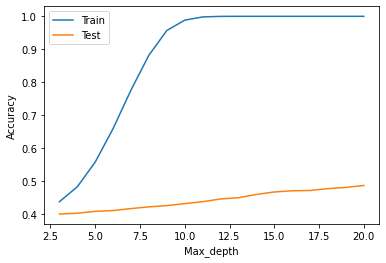

In [29]:
plt.plot(np.arange(3, 21, 1), xgbc_train, label="Train")
plt.plot(np.arange(3, 21, 1),xgbc_test, label="Test")
plt.legend()
plt.xlabel("Max_depth")
plt.ylabel("Accuracy")
plt.show()

In [27]:
XGBC = XGBClassifier(max_depth = 20,  tree_method='gpu_hist')
XGBC.fit(X_train1, y_train1)
print(XGBC.score(X_train1, y_train1))
print(XGBC.score(X_test1, y_test1))
res_XGBC = pd.DataFrame(confusion_matrix(y_test1, XGBC.predict(X_test1)), 
             columns=["Predict:0(up)", "Predict:1(stay)", "Predict:2(down)"], 
             index=["Actual:0(up)", "Actual:1(stay)", "Actual:2(down)"])
print( res_XGBC )

C:\Users\takayuki\.conda\envs\keras-gpu\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:41:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
1.0
0.48700300212345315
                Predict:0(up)  Predict:1(stay)  Predict:2(down)
Actual:0(up)             6490             4634             2685
Actual:1(stay)           3318             8215             2933
Actual:2(down)           2792             4656             5248


(4)LSTM

In [130]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 17761303604914974175,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 1334162227
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 18222241465395988628
 physical_device_desc: "device: 0, name: GeForce GTX 960, pci bus id: 0000:01:00.0, compute capability: 5.2"]

In [131]:
X_train_keras = X_train2.values.reshape(X_train2.shape[0], X_train2.shape[1], 1)
X_test_keras = X_test2.values.reshape(X_test2.shape[0], X_test2.shape[1], 1)

In [132]:
X_train_keras.shape

(122912, 60, 1)

In [133]:
length = X_train_keras.shape[1]
num_feature = X_train_keras.shape[2]

model = Sequential()

#model.add(GRU(128, input_shape=(length, num_feature), return_sequences=False))

model.add(GRU(128, input_shape=(length, num_feature), return_sequences=True))
model.add(GRU(128, input_shape=(length, num_feature), return_sequences=False))
model.add(Dense(3, activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer="Adam")
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_4 (GRU)                  (None, 60, 128)           50304     
_________________________________________________________________
gru_5 (GRU)                  (None, 128)               99072     
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 387       
Total params: 149,763
Trainable params: 149,763
Non-trainable params: 0
_________________________________________________________________
None


In [134]:
with tf.device('/GPU:0'):
    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')
    history = model.fit(X_train_keras, y_train2, 
              batch_size=128, 
              epochs=200,
              validation_split=0.1,
              callbacks = [es],
              shuffle=False)

Train on 110620 samples, validate on 12292 samples
Epoch 1/200
110620/110620 [==============================] - 26s 238us/sample - loss: 1.0958 - val_loss: 1.0948
Epoch 2/200
110620/110620 [==============================] - 17s 155us/sample - loss: 1.0815 - val_loss: 1.0776
Epoch 3/200
110620/110620 [==============================] - 17s 155us/sample - loss: 1.0770 - val_loss: 1.0747
Epoch 4/200
110620/110620 [==============================] - 17s 154us/sample - loss: 1.0749 - val_loss: 1.0740
Epoch 5/200
110620/110620 [==============================] - 17s 154us/sample - loss: 1.0727 - val_loss: 1.0727
Epoch 6/200
110620/110620 [==============================] - 17s 155us/sample - loss: 1.0710 - val_loss: 1.0709
Epoch 7/200
110620/110620 [==============================] - 17s 155us/sample - loss: 1.0694 - val_loss: 1.0704
Epoch 8/200
110620/110620 [==============================] - 17s 155us/sample - loss: 1.0669 - val_loss: 1.0681
Epoch 9/200
110620/110620 [==========================

In [135]:
json_string = model.to_json()
open('model.json', 'w').write(json_string)
model.save_weights("param.hdf5")

In [136]:
model.save('model.h5', include_optimizer=False)

In [137]:
y_train_pred = np.argmax( model.predict(X_train_keras) , axis=1)
y_train_actual = np.argmax(y_train2, axis=1)
y_test_pred = np.argmax( model.predict(X_test_keras) , axis=1)
y_test_actual = np.argmax(y_test2, axis=1)

In [138]:
res_keras = pd.DataFrame(confusion_matrix(y_test_actual, y_test_pred), 
             columns=["Predict:0(up)", "Predict:1(stay)", "Predict:2(down)"], 
             index=["Actual:0(up)", "Actual:1(stay)", "Actual:2(down)"])
print( res_keras )

                Predict:0(up)  Predict:1(stay)  Predict:2(down)
Actual:0(up)             9626             3005             1178
Actual:1(stay)           2627             8957             2882
Actual:2(down)            883             2793             9020


In [139]:
print( accuracy_score(y_train_actual, y_train_pred) )

print( accuracy_score(y_test_actual, y_test_pred) )

0.7484541785993231
0.6737204364062386


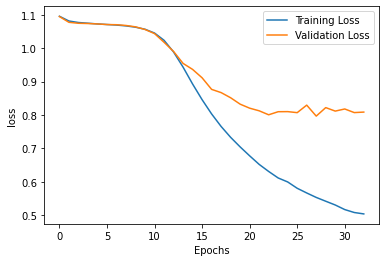

In [140]:
plt.plot( history.history['loss'], label='Training Loss' )
plt.plot( history.history['val_loss'], label='Validation Loss' )
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

In [102]:
model2 =load_model("model.h5", compile=False)

In [103]:
y_train_pred = np.argmax( model2.predict(X_train_keras) , axis=1)
y_train_actual = np.argmax(y_train2, axis=1)
y_test_pred = np.argmax( model2.predict(X_test_keras) , axis=1)
y_test_actual = np.argmax(y_test2, axis=1)

In [104]:
res_keras = pd.DataFrame(confusion_matrix(y_test_actual, y_test_pred), 
             columns=["Predict:0(up)", "Predict:1(stay)", "Predict:2(down)"], 
             index=["Actual:0(up)", "Actual:1(stay)", "Actual:2(down)"])
print( res_keras )

                Predict:0(up)  Predict:1(stay)  Predict:2(down)
Actual:0(up)             9097             2635             1304
Actual:1(stay)           3442             8630             2578
Actual:2(down)           1953             2651             8327


In [32]:
json_string = open("model.json").read()
model3 = model_from_json(json_string)
model3.load_weights("param.hdf5")

In [106]:
X_train_keras = X_train2.values.reshape(X_train2.shape[0], X_train2.shape[1], 1)
X_test_keras = X_test2.values.reshape(X_test2.shape[0], X_test2.shape[1], 1)
y_train_pred = np.argmax( model3.predict(X_train_keras) , axis=1)
y_train_actual = np.argmax(y_train2, axis=1)
y_test_pred = np.argmax( model3.predict(X_test_keras) , axis=1)
y_test_actual = np.argmax(y_test2, axis=1)

In [107]:
res_keras = pd.DataFrame(confusion_matrix(y_test_actual, y_test_pred), 
             columns=["Predict:0(up)", "Predict:1(stay)", "Predict:2(down)"], 
             index=["Actual:0(up)", "Actual:1(stay)", "Actual:2(down)"])
print( res_keras )

                Predict:0(up)  Predict:1(stay)  Predict:2(down)
Actual:0(up)             9097             2635             1304
Actual:1(stay)           3442             8630             2578
Actual:2(down)           1953             2651             8327


# Validation

In [30]:
valid_df = pd.read_csv("valid.csv")

In [33]:
valid_pred1 = model3.predict( valid_df.iloc[:, 2:].values.reshape(49, 60, 1) )

In [34]:
temp = valid_df.iloc[:, 2:]
temp_col = {}
for i in range(len(temp.columns.values)):
    temp_col[temp.columns.values[i]] = X_train1.columns.values[i]
temp = temp.rename(columns=temp_col)

In [37]:
pd.DataFrame( np.vstack([ valid_df.iloc[:, 1].values , np.argmax(valid_pred1, axis=1) ]).T , columns=["ticker", "label(GRU)"]).sort_values("ticker").to_csv("pred1.csv", index=None)